<a href="https://colab.research.google.com/github/amasoudi1/UNet-in-Tensorflow/blob/master/UNET_Fixed_Gantry2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q pyyaml  # pyyaml is an optional
!pip install -U -q PyDrive  # PyDrive you can upload/download read and write data

     |████████████████████████████████| 993kB 9.2MB/s 


In [0]:
#import tensorflow as tf
#from tensorflow.keras import layers
#from tensorflow.python.client import device_lib


#print(tf.VERSION)
#print(tf.keras.__version__)
#device_lib.list_local_devices()

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
cd /content/gdrive/'My Drive'/'Colab Notebooks'/

/content/gdrive/My Drive/Colab Notebooks


In [5]:
ls

data_label/           rfg_v2.h5                 train_images_128/
data_reconstruction/  test_data/                train_images_norm_128/
FbpConvNet.ipynb      test_data_128/            training/
model100.h5           test_images_128/          train_label_conv_rfg_100/
model100v2.h5         test_images_norm_128/     train_labels_128/
model100v3.h5         test_label_conv_rfg_100/  train_labels_norm_128/
model100v4.h5         test_labels_128/          train_rec_conv_rfg_100/
model100v5.h5         test_labels_norm_128/     UNET_Fixed_Gantry2.ipynb
model1.h5             test_rec_conv_rfg_100/    Untitled0.ipynb
model.h5              train_data/
rfg.h5                train_data_128/


In [6]:
import os
import sys

try:
 device_name = os.environ['COLAB_TPU_ADDR']
 TPU_ADDRESS = 'grpc://' + device_name
 print('Found TPU at: {}'.format(TPU_ADDRESS))
except KeyError:
 print('TPU not found')

TPU not found


[  50 1188  636 1993 1034 1774  609 1752 1496 1305  102 1606 1928 1883
  170  905  213  732  856 1915]
Done With Data


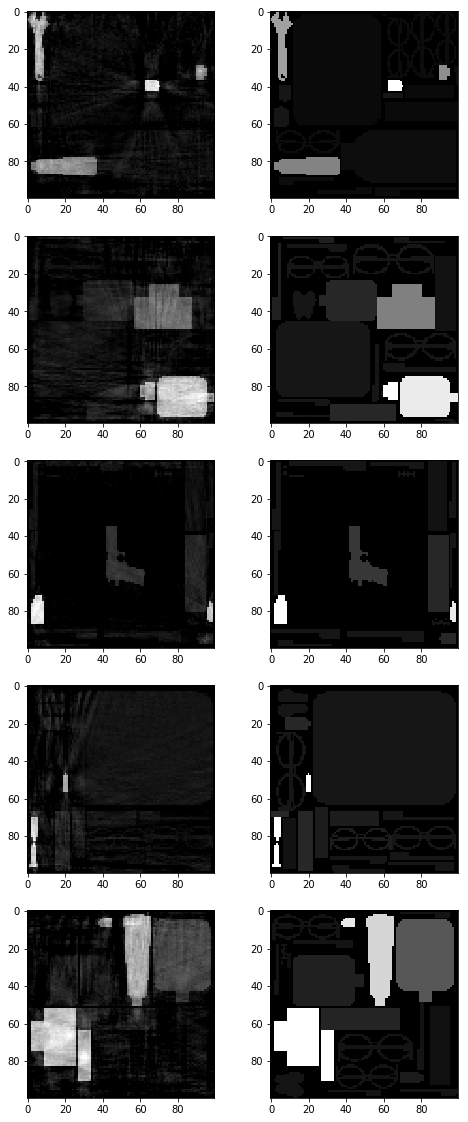

In [9]:
#from tensorflow.keras.models import *
#from tensorflow.keras.layers import *
#from tensorflow.keras.optimizers import *
#from tensorflow.keras.initializers import *
#from tf.keras.callbacks import ModelCheckpoint, LearningRateScheduler
#from tf.keras import backend as keras

from keras.models import Model
from keras.layers import *
from keras.optimizers import *
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
from keras.callbacks import LearningRateScheduler, ModelCheckpoint ,Callback
from keras.initializers import *

import numpy as np
import scipy.io as sc
import os
import sys
from sklearn.utils import shuffle
#from scipy.ndimage import imread
from imageio import imread
#from scipy.misc import imresize
import matplotlib.pyplot as plt

#np.random.seed(0)
#tf.set_random_seed(0)
#print(tf.VERSION)
#print(tf.keras.__version__)


train_images = np.zeros(shape=(1800,100,100,1))
train_labels = np.zeros(shape=(1800,100,100,1))

test_images = np.zeros(shape=(200,100,100,1))
test_labels = np.zeros(shape=(200,100,100,1))

indx = np.arange(2000)
np.random.shuffle(indx)
print(indx[1980:2000])

# --- get training data ---
images_location = "./data_reconstruction/"
labels_location = "./data_label/"

for i in range(1800):    
    image_temp = sc.loadmat(images_location + str(indx[i]+1) + ".mat")    
    train_images[i,:,:]   = np.expand_dims(np.array(image_temp['r']),axis=2)
    
    label_temp = sc.loadmat(labels_location + str(indx[i]+1) + ".mat")    
    train_labels[i,:,:]   = np.expand_dims(np.array(label_temp['t']),axis=2)
    
                
# --- get test data ---
#images_location = "./test_rec_conv_rfg_100/"
#labels_location = "./test_label_conv_rfg_100/"
      
counter = 0  
for i in range(1800,2000):      
    image_temp = sc.loadmat(images_location + str(indx[i]+1) + ".mat")    
    test_images[counter,:,:]   = np.expand_dims(np.array(image_temp['r']),axis=2)
    
    label_temp = sc.loadmat(labels_location + str(indx[i]+1) + ".mat")    
    test_labels[counter,:,:]   = np.expand_dims(np.array(label_temp['t']),axis=2)
    counter += 1
      
#train_images = 1*(train_images - train_images.min()) / (train_images.max() - train_images.min())
#train_labels = 1*(train_labels - train_labels.min()) / (train_labels.max() - train_labels.min())      
      
print("Done With Data")
fix, ax = plt.subplots(5,2, figsize=(8,20))
for i in range(5):
    ax[i,0].imshow(train_images[i,:,:,0], cmap='gray')
    ax[i,1].imshow(train_labels[i,:,:,0], cmap='gray')
plt.show()

#fix, ax = plt.subplots(1,2, figsize=(8,20))
#ax[0].imshow(train_images[0,:,:,0], cmap='gray')
#ax[1].imshow(train_labels[0,:,:,0], cmap='gray')
#plt.show()

In [0]:
# Defining
SEED = 42
#initializer = RandomNormal(mean=0.0, stddev=0.05, seed = SEED) 
initializer = glorot_normal(seed = SEED) 
inputs = Input(shape=(100,100,1))  # Returns a placeholder tensor

### Layers :
# LEVEL 1
L10 = Conv2D(1, (1, 1), activation='relu', padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(inputs)
L11 = Conv2D(64, (1, 1), activation='relu', padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(L10)
L11 = BatchNormalization()(L11)
L12 = Conv2D(64, (3, 3), activation='relu' , padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(L11)
L12 = BatchNormalization()(L12)
L13 = Conv2D(64, (3, 3), activation='relu' , padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(L12)
L13 = BatchNormalization()(L13)

# LEVEL 2
L20 = MaxPooling2D(pool_size=(2, 2), padding='valid')(L13)
L21 = Conv2D(128, (3, 3), activation='relu' , padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(L20)
L21 = BatchNormalization()(L21)
L22 = Conv2D(128, (3, 3), activation='relu' , padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(L21)
L22 = BatchNormalization()(L22)

# LEVEL 3
L30 = MaxPooling2D(pool_size=(2, 2), padding='valid')(L22)
L31 = Conv2D(256, (3, 3), activation='relu' , padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(L30)
L31 = BatchNormalization()(L31)
L32 = Conv2D(256, (3, 3), activation='relu' , padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(L31)
L32 = BatchNormalization()(L32)

# LEVEL 4
L40 = MaxPooling2D(pool_size=(2, 2), padding='valid')(L32)
L41 = Conv2D(512, (3, 3), activation='relu' , padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(L40)
L41 = BatchNormalization()(L41)
L42 = Conv2D(512, (3, 3), activation='relu' , padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(L41)
L42 = BatchNormalization()(L42)

# LEVEL 5
L50 = MaxPooling2D(pool_size=(2, 2), padding='valid')(L42)
L51 = Conv2D(1024, (3, 3), activation='relu' , padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(L50)
L51 = BatchNormalization()(L51)
L52 = Conv2D(1024, (3, 3), activation='relu' ,padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(L51)
L52 = BatchNormalization()(L52)

# LEVEL 4
L43_in = Conv2DTranspose(256, (3, 3), activation='relu' , strides=(2, 2) ,padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(L52)
#L43_in = UpSampling2D(size=(2,2))(L52)
L43_in = BatchNormalization()(L43_in)
L43 = Conv2D(512, (3, 3), activation='relu' ,padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(concatenate([L42,L43_in], axis = 3))
L43 = BatchNormalization()(L43)
L44 = Conv2D(512, (3, 3), activation='relu' ,padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(L43)
L44 = BatchNormalization()(L44)

# LEVEL 3
L33_in = Conv2DTranspose(128, (3, 3), activation='relu', strides=(2, 2) ,padding='valid',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(L44)
#L33_in = UpSampling2D(size=(2,2))(L44)
L33_in = BatchNormalization()(L33_in)
L33 = Conv2D(256, (3, 3), activation='relu' , padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(concatenate([L32,L33_in], axis = 3))
L33 = BatchNormalization()(L33)
L34 = Conv2D(256, (3, 3), activation='relu' ,padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(L33)
L34 = BatchNormalization()(L34)

# LEVEL 2
L23_in = Conv2DTranspose(64, (3, 3), activation='relu' , strides=(2, 2) ,padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(L34)
#L23_in = UpSampling2D(size=(2,2))(L34)
L23_in = BatchNormalization()(L23_in)
L23 = Conv2D(128, (3, 3), activation='relu' ,padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(concatenate([L22,L23_in], axis = 3))
L23 = BatchNormalization()(L23)
L24 = Conv2D(128, (3, 3), activation='relu' , padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(L23)
L24 = BatchNormalization()(L24)

# LEVEL 1
L14_in = Conv2DTranspose(32, (3, 3), activation='relu' , strides=(2, 2) ,padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(L24)
#L14_in = UpSampling2D(size=(2,2))(L24)
L14_in = BatchNormalization()(L14_in)
L14 = Conv2D(64, (3, 3), activation='relu' , padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(concatenate([L13,L14_in], axis = 3))
L14 = BatchNormalization()(L14)
L15 = Conv2D(64, (3, 3), activation='relu' , padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(L14)
L15 = BatchNormalization()(L15)
L16 = Conv2D(1, (1, 1), activation='relu' , padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(L15)
feed_forward = Add()([L10,L16])
L17 = Conv2D(1, (1, 1), padding='same',use_bias=True, kernel_initializer= initializer, bias_initializer='zeros')(feed_forward)


model = Model(inputs=inputs, outputs=L17)
model.summary()




In [0]:
def my_generator(x_train, y_train, batch_size):
    data_generator = ImageDataGenerator(width_shift_range = 0.1, height_shift_range = 0.1).flow(x_train, x_train, batch_size, seed=SEED)
    mask_generator = ImageDataGenerator(width_shift_range = 0.1, height_shift_range = 0.1).flow(y_train, y_train, batch_size, seed=SEED)
    while True:
        x_batch, _ = data_generator.next()
        y_batch, _ = mask_generator.next()
        yield x_batch, y_batch

In [0]:

image_batch, mask_batch = next(my_generator(train_images, train_labels, 5))
fix, ax = plt.subplots(5,2, figsize=(8,20))
for i in range(5):
    ax[i,0].imshow(image_batch[i,:,:,0], cmap='gray')
    ax[i,1].imshow(mask_batch[i,:,:,0], cmap='gray')
plt.show()

In [0]:
#sgd = SGD(lr=1e-4, momentum=0.99, nesterov = True, clipvalue=0.01)
#sgd = SGD(lr=1, momentum=0.99, clipvalue=0.01)
#sgd = tf.train.MomentumOptimizer(learning_rate = 0.01, momentum=0.99)

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

model.compile(Adam(lr = 0.01), loss='mean_squared_error', metrics=['mean_absolute_error'])
#model.compile(sgd, loss='mean_squared_error', metrics=['mean_absolute_error'])

weight_saver = ModelCheckpoint('./rfg_v3.h5', monitor='val_loss',
                               save_best_only=True, save_weights_only=True)

#annealer = LearningRateScheduler(lambda x: 0.99 ** x)

In [0]:

#model.load_weights('rfg.h5')
#model.compile(Adam(lr = 0.01), loss='mean_squared_error', metrics=['mean_absolute_error'])
#loss, acc = model.evaluate(train_images,train_labels)
#print(loss)
#print(acc)

#history = LossHistory()
#hist = model.fit(train_images, train_labels, batch_size = 32, epochs = 2000, validation_data = (test_images,test_labels), 
#          shuffle = True ,verbose = 1, callbacks = [weight_saver,history])#, annealer])
hist = model.fit_generator(my_generator(train_images, train_labels, 32),
                           epochs=1000, verbose=1,
                           steps_per_epoch = 2000,
                           callbacks = [weight_saver])#, annealer])

Instructions for updating:
Use tf.cast instead.
Train on 1980 samples, validate on 20 samples
Epoch 1/2000
1980/1980 [==============================] - 38s 19ms/step - loss: 89166.4992 - mean_absolute_error: 258.3687 - val_loss: 57971.9883 - val_mean_absolute_error: 172.2414
Epoch 2/2000
1980/1980 [==============================] - 22s 11ms/step - loss: 36321.9426 - mean_absolute_error: 102.5968 - val_loss: 49926.2383 - val_mean_absolute_error: 134.6702
Epoch 3/2000
1980/1980 [==============================] - 22s 11ms/step - loss: 35919.5591 - mean_absolute_error: 100.2638 - val_loss: 45753.9258 - val_mean_absolute_error: 126.1838
Epoch 4/2000
1980/1980 [==============================] - 23s 12ms/step - loss: 35693.3709 - mean_absolute_error: 98.8606 - val_loss: 46030.2109 - val_mean_absolute_error: 125.0367
Epoch 5/2000
1980/1980 [==============================] - 23s 12ms/step - loss: 35459.9797 - mean_absolute_error: 97.4480 - val_loss: 45042.1484 - val_mean_absolute_error: 122.823

KeyboardInterrupt: ignored

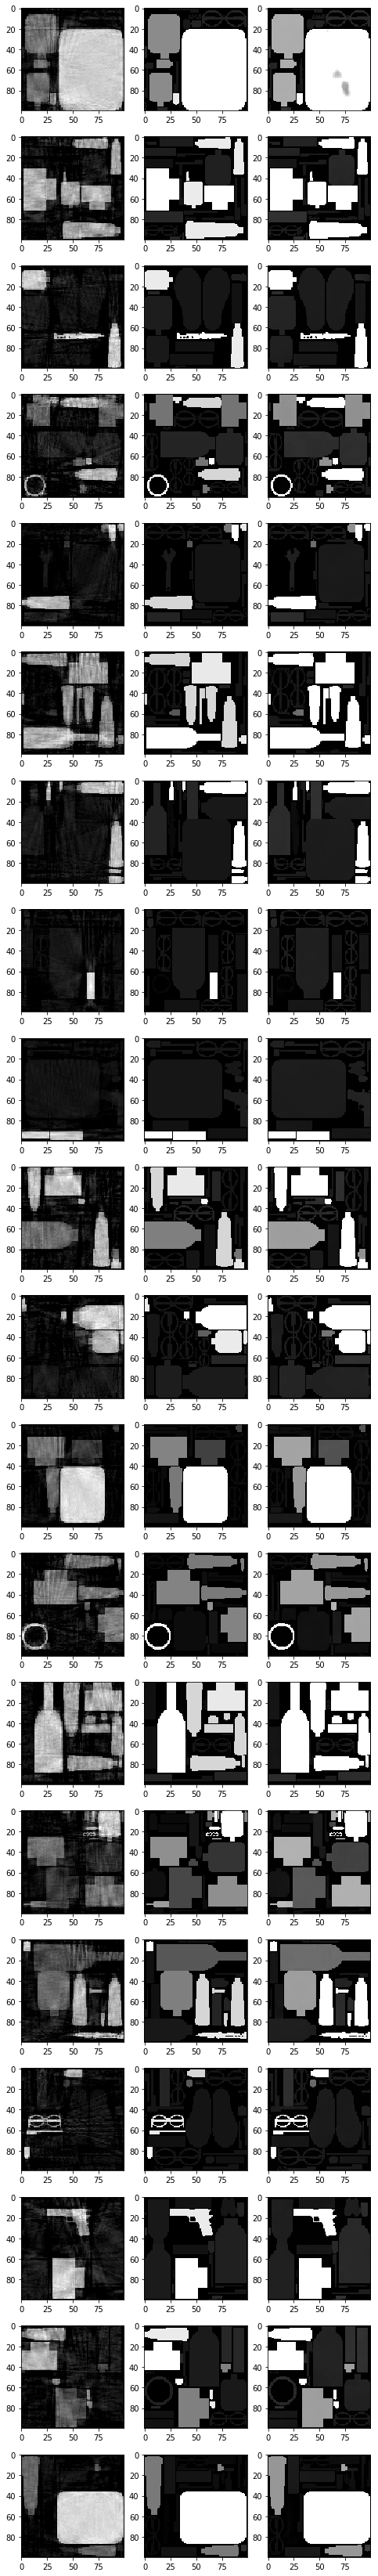

In [0]:
#model.load_weights('model1.h5')

#print(hist.history.keys())

#index = 0
#fix, ax = plt.subplots(2,1, figsize=(20,8))
#ax[0].plot(hist.history['mean_squared_error'])
#ax[1].plot(hist.history['mean_absolute_error'])

#image_batch, mask_batch = next(my_generator(train_images, train_labels, 5))
fix, ax = plt.subplots(20,3, figsize=(8,60))
for i in range(20):
    ax[i,0].imshow(train_images[i,:,:,0], cmap='gray')
    ax[i,1].imshow(train_labels[i,:,:,0], cmap='gray')
    temp = model.predict( np.expand_dims( np.expand_dims(train_images[i,:,:,0], axis = 0), axis = 3 ))
    ax[i,2].imshow(np.squeeze(temp), cmap='gray')
plt.show()

# Test
798.0172-22.4618

20/20 [==============================] - 0s 6ms/step
5072.3935546875
36.12358093261719


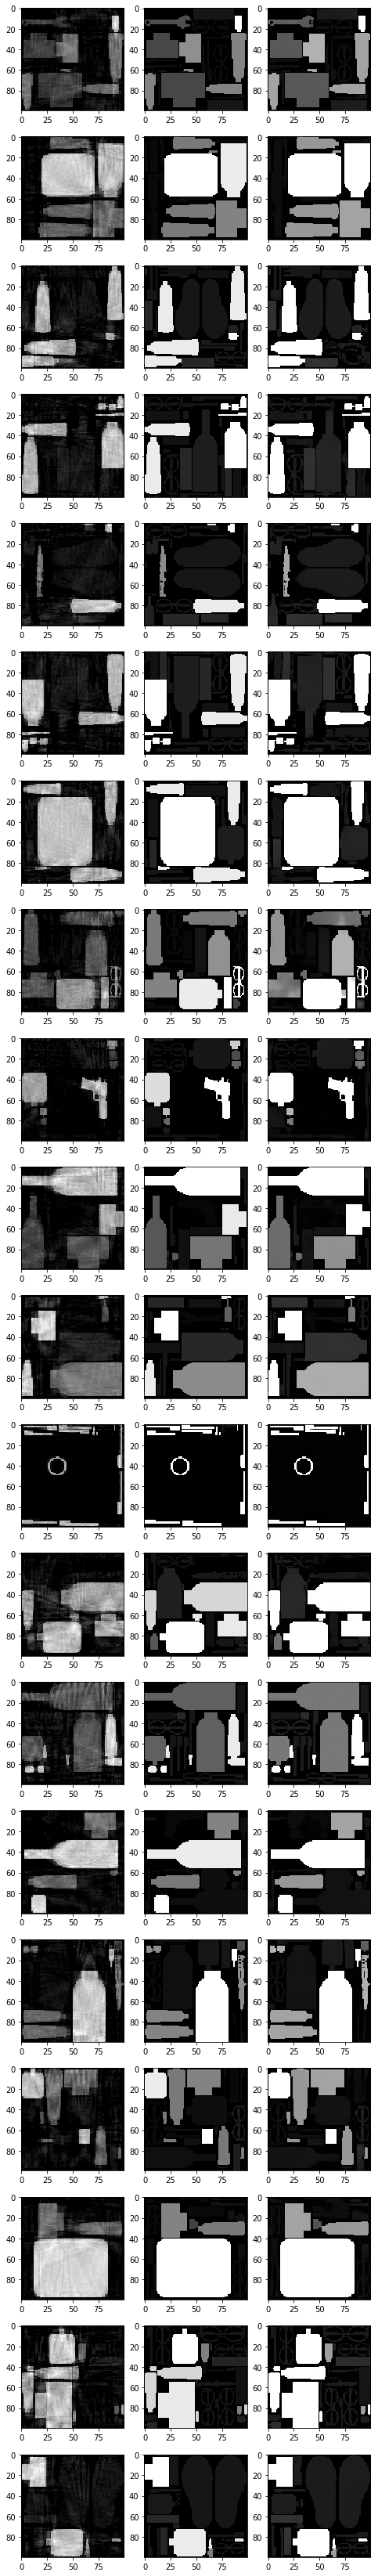

In [0]:
model.load_weights('rfg_v2.h5')
#model.compile(Adam(lr = 0.01), loss='mean_squared_error', metrics=['mean_absolute_error'])

loss, acc = model.evaluate(test_images,test_labels)
print(loss)
print(acc)
fix, ax = plt.subplots(20,3, figsize=(8,60))
for i in range(20):    
    ax[i,0].imshow(test_images[i,:,:,0], cmap='gray')
    ax[i,1].imshow(test_labels[i,:,:,0], cmap='gray')
    temp = model.predict( np.expand_dims( np.expand_dims(test_images[i,:,:,0], axis = 0), axis = 3 ))
    ax[i,2].imshow(np.squeeze(temp), cmap='gray')
plt.show()